In [ ]:
%%shell
set -e

#---------------------------------------------------#
JULIA_VERSION="1.10.4" # any version ≥ 0.7.0
JULIA_PACKAGES="IJulia BenchmarkTools DataFrames CSV Query Plots GLM"
JULIA_PACKAGES_IF_GPU="CUDA" # or CuArrays for older Julia versions
JULIA_NUM_THREADS=2
#---------------------------------------------------#

if [ -z `which julia` ]; then
  # Install Julia
  JULIA_VER=`cut -d '.' -f -2 <<< "$JULIA_VERSION"`
  echo "Installing Julia $JULIA_VERSION on the current Colab Runtime..."
  BASE_URL="https://julialang-s3.julialang.org/bin/linux/x64"
  URL="$BASE_URL/$JULIA_VER/julia-$JULIA_VERSION-linux-x86_64.tar.gz"
  wget -nv $URL -O /tmp/julia.tar.gz # -nv means "not verbose"
  tar -x -f /tmp/julia.tar.gz -C /usr/local --strip-components 1
  rm /tmp/julia.tar.gz

  # Install Packages
  nvidia-smi -L &> /dev/null && export GPU=1 || export GPU=0
  if [ $GPU -eq 1 ]; then
    JULIA_PACKAGES="$JULIA_PACKAGES $JULIA_PACKAGES_IF_GPU"
  fi
  for PKG in `echo $JULIA_PACKAGES`; do
    echo "Installing Julia package $PKG..."
    julia -e 'using Pkg; pkg"add '$PKG'; precompile;"' &> /dev/null
  done

  # Install kernel and rename it to "julia"
  echo "Installing IJulia kernel..."
  julia -e 'using IJulia; IJulia.installkernel("julia", env=Dict(
      "JULIA_NUM_THREADS"=>"'"$JULIA_NUM_THREADS"'"))'
  KERNEL_DIR=`julia -e "using IJulia; print(IJulia.kerneldir())"`
  KERNEL_NAME=`ls -d "$KERNEL_DIR"/julia*`
  mv -f $KERNEL_NAME "$KERNEL_DIR"/julia

  echo ''
  echo "Successfully installed `julia -v`!"
  echo "Please reload this page (press Ctrl+R, ⌘+R, or the F5 key) then"
  echo "jump to the 'Checking the Installation' section."
fi

<h2>Example 1: Data Import, Summary, and Cleanup</h2>
Task: Import, identify and handle missing or inconsistent data.

In [ ]:
#import the Iris dataset
run(pipeline(`wget -nv https://gist.githubusercontent.com/curran/a08a1080b88344b0c8a7/raw/0e7a9b0a5d22642a06d3d5b9bcbad9890c8ee534/iris.csv -O /tmp/iris.csv`))

In [ ]:
# import the packages we need
using Pkg
Pkg.add(["CSV","DataFrames", "Statistics", "StatsPlots", "Plots"])
using CSV
using DataFrames
using Statistics

In [ ]:
# creating a dataframe from the dataset
input_file = joinpath("/tmp", "iris.csv");
iris_df = DataFrame(CSV.File(input_file));

In [ ]:
println(first(iris_df, 5))

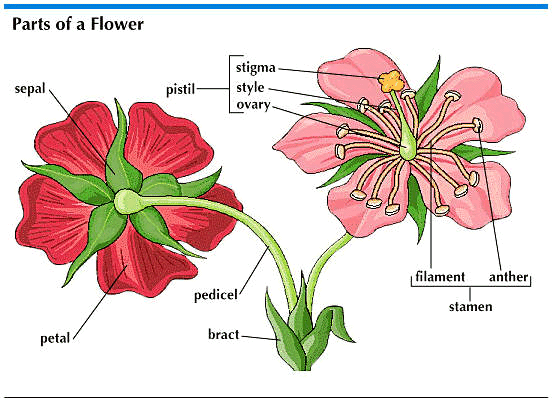

<b>Check for missing values:</b>

In [ ]:
# Count missing values in each column
missing_counts = map(col -> count(ismissing, col), eachcol(iris_df))

#Pair column names with their missing counts
missing_summary = pairs(missing_counts) |>
                  collect .|> x -> (names(iris_df)[x[1]], x[2])

println("Missing values per column:")
println(missing_summary)

<b>Handle missing values:</b>

In [ ]:
using Statistics

# Replace missing values in numerical columns with the mean
# This is not necessary in this case, but the code is useful to have since a lot of datasets will
# have some missing data

for col in [:sepal_length, :sepal_width, :petal_length, :petal_width]
    iris_df[!, col] = coalesce.(iris_df[!, col], mean(skipmissing(iris_df[!, col])))
end

# coalesce is the function to replace missing data fields with whatever you specify

println("After handling missing values:")
println(first(iris_df, 5))

In [ ]:
# Write the cleaned up data to a CSV file
CSV.write("cleaned_iris.csv", iris_df)
println("Cleaned dataset saved as 'cleaned_iris.csv'")

**Challenge:** Identify Outliers in Sepal Width

Identify any rows in the dataset where `the sepal_width` is significantly lower or higher than average (e.g., beyond 1.5 times the interquartile range).
```
# Guidance:

# 1. Compute Q1 (25th percentile) and Q3 (75th percentile) for 'sepal_width'
# 2. Calculate the IQR (Q3 - Q1).
# 3. Identify rows where 'sepal_width' is outside [Q1 - 1.5*IQR, Q3 + 1.5*IQR].

# Write code to compute and filter outliers in the block below:
```



In [ ]:
# Step 1: Compute the IQR for sepal_width
Q1 = quantile(iris_df.sepal_width, 0.25)  # First quartile (25th percentile)
Q3 = quantile(iris_df.sepal_width, 0.75)  # Third quartile (75th percentile)
IQR = Q3 - Q1                            # Interquartile range

# Step 2: Define outlier thresholds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Step 3: Identify rows with outliers
outliers = iris_df[(iris_df.sepal_width .< lower_bound) .| (iris_df.sepal_width .> upper_bound), :]

# Print the results
println("Outlier thresholds for sepal_width:")
println("Lower bound: $lower_bound, Upper bound: $upper_bound")

println("\nRows with outliers in sepal_width:")
println(outliers)

<h2>Excercise 2: Descriptive Statistics and Group Analysis</h2>

<b>Task:</b> Compare sepal and petal dimensions by species.

In [ ]:
using Statistics
summary = combine(groupby(iris_df, :species),
                  :sepal_length => mean,
                  :sepal_width => mean,
                  :petal_length => mean,
                  :petal_width => mean)
println(summary)

**Questions:**

  1. Which species has the longest average petal length?

  2. Is there a pattern in sepal width among the species?



**Challenge:** Find the Species with the Most Flowers Over a Certain Petal Length

**Question:** For each species, how many flowers have a petal_length greater than 4?

**Hint:** Use groupby to group by species, and then use count with a condition on petal_length.

Ex. look here: https://juliadatascience.io/groupby_combine

```
# Guidance:
# 1. Group data by `species`.
# 2. Count how many flowers in each group have a `petal_length` greater than 4.

# Write code to calculate the number of flowers with petal_length > 4 for each species here.

```



In [ ]:
# Step 1: Group data by species
grouped_data = groupby(iris_df, :species)

# Step 2: Compute the standard deviation of petal_length for each species
species_std = combine(grouped_data, :petal_length => std => :std_petal_length)

# :petal_length refers to the petal_length column in the grouped data.
# std is the function that calculates the standard deviation. It is applied to the petal_length column for each group (species).
# :std_petal_length is the name of the new column that will store the standard deviation results.
# So, for each species group, we compute the standard deviation of the petal_length values and name the new column std_petal_length.

# Step 3: Find the species with the smallest standard deviation
min_std_species = species_std[argmin(species_std.std_petal_length), :]

println("Species with the smallest variation in petal length:")
println(min_std_species)

<h2>Excercise 3: Data Visualization</h2>

<b>Task:</b> Visualize feature distributions and relationships.


<h4>1. Plot distribution of Petal Lengths by Species:</h4>

In [ ]:
using Plots

histogram(iris_df.petal_length,
          bins=20,
          group=iris_df.species,
          xlabel="Petal Length (cm)",
          ylabel="Frequency",
          title="Distribution of Petal Lengths by Species")

<h4>2. Scatter plot to examine relationship of sepal dimensions and species:</h4>

In [ ]:
scatter(iris_df.sepal_length, iris_df.sepal_width,
        group=iris_df.species,
        xlabel="Sepal Length (cm)",
        ylabel="Sepal Width (cm)",
        title="Sepal Dimensions by Species")

**Challenge:** Plot Sepal Dimensions with a Color-Coded Legend

Create a scatter plot to compare sepal_length vs. sepal_width, but color-code the points based on the species. Include a legend to distinguish the species visually.

**Hint:** Use the markersize argument in the scatter function.

```
# Guidance:
# 1. Plot `sepal_length` vs. `sepal_width`.
# 2. Use `iris_df.petal_length` to define marker sizes.
# 3. Group markers by species to distinguish classes visually.

# Write code to create the scatter plot here.
```

In [ ]:
# Step 1: Create a scatter plot comparing sepal_length and sepal_width
# Step 2: Use petal_length to define marker sizes

# Define a color map for species
species_colors = Dict(
    "setosa" => :blue,
    "versicolor" => :green,
    "virginica" => :red
)

# Map species to colors
colors = [species_colors[species] for species in iris_df.species]

# Create a scatter plot with marker sizes based on petal_length
scatter(iris_df.sepal_length, iris_df.sepal_width,
        markersize=iris_df.petal_length * 2,  # Adjust size based on petal_length
        color=colors,                        # Use the mapped species colors
        xlabel="Sepal Length", ylabel="Sepal Width",
        title="Sepal Length vs Sepal Width (Marker size by Petal Length)",
        legend=:topleft, grid=true)

<h2>Excercise 4: Feature Engineering</h2>

<b>Task:</b> Create a new feature (petal-to-sepal ratio), and analyze its importance.

1. Create a new feature (petal-to-sepal ratio):

In [ ]:
using StatsPlots
iris_df.petal_sepal_ratio = iris_df.petal_length ./ iris_df.sepal_length
println(first(iris_df, 5))

2. Compare the new feature across species:

In [ ]:
ratio_summary = combine(groupby(iris_df, :species), :petal_sepal_ratio => mean)
println(ratio_summary)

3. Visualization:

In [ ]:
using StatsPlots
@df iris_df boxplot(
    :species,
    :petal_sepal_ratio,
    xlabel="Species",
    ylabel="Petal-to-Sepal Ratio",
    title="Petal-to-Sepal Ratio by Species"
)

**Challenge:** Explore New Features

**Question:** Create a new feature called sepal_area (sepal length × sepal width) and identify the species with the largest average sepal area.

**Hint:** Add a new column to the DataFrame for sepal_area and use groupby and combine to calculate averages.

```
# Guidance:
# 1. Compute a new column `sepal_area`.
# 2. Group by `species` and calculate the mean `sepal_area`.
# 3. Identify the species with the largest average.

# Write code to compute the new feature and analyze it here.
```


In [ ]:
# Step 1: Compute a new column `sepal_area`
iris_df.sepal_area = iris_df.sepal_length .* iris_df.sepal_width

# Step 2: Group by `species` and calculate the mean `sepal_area`
using Statistics
species_avg_sepal_area = combine(groupby(iris_df, :species), :sepal_area => mean => :avg_sepal_area)

# Step 3: Identify the species with the largest average sepal_area
max_avg_species = species_avg_sepal_area[argmax(species_avg_sepal_area.avg_sepal_area), :]

# Output the species name and the largest average sepal area
largest_species = max_avg_species.species
largest_avg_sepal_area = max_avg_species.avg_sepal_area

# Print output
println("Species with the largest average sepal area: $largest_species with an average sepal area of $largest_avg_sepal_area")
println(max_avg_species)

<h2> Example 5: Correlation Analysis </h2>
<b>Task:</b> Explore the relationships between numerical features.

1. Compute Correlations:

In [ ]:
# Ensure we only select numerical columns for the correlation matrix
numerical_columns = [:sepal_length, :sepal_width, :petal_length, :petal_width]

# Calculate the correlation matrix (excluding the species column)
corr_matrix = cor(Matrix(select(iris_df, numerical_columns)))

corr_matrix = cor(Matrix(select(iris_df, Not(:species))))
#println(corr_matrix)
# Format and display as a grid-like box
column_names = names(select(iris_df, Not(:species)))

println("Correlation Matrix:")
println(join(["       " * join(column_names, "     ")], "\n"))  # Header row

for (i, row) in enumerate(eachrow(corr_matrix))
    println(column_names[i], " | ", join(round.(row, digits=2), "  "))
end

<h4>What Correlation Means</h4>

1. **Correlation Coefficient (r):**
*   Range: -1 to 1
*   Positive correlation (r > 0): As one variable increases, the other tends to increase.
*   Negative correlation (r < 0): As one variable increases, the other tends to decrease.
*   No correlation (r ≈ 0): There is no linear relationship between the two variables.

2. **Strength of Correlation:**
*   |r| ≈ 0 to 0.3: Weak correlation
*   |r| ≈ 0.3 to 0.7: Moderate correlation
*   |r| ≈ 0.7 to 1: Strong correlation

In [ ]:
using Plots
heatmap(corr_matrix, title="Correlation Matrix", xlabel="Features", ylabel="Features")


Another way to see the correlation between certain values is to create scatterplots for the different relations. Below is an example of comparing the values of the sepal length vs the petal length:

In [ ]:
scatter(iris_df.sepal_length, iris_df.petal_length,
        xlabel="Sepal Length", ylabel="Petal Length",
        title="Sepal Length vs Petal Length")

Challenge: Create the other scatter plots

In [ ]:
# Sepal Width vs Petal Width
scatter(iris_df.sepal_width, iris_df.petal_width, xlabel="Sepal Width", ylabel="Petal Width", title="Sepal Width vs Petal Width")

In [ ]:
# Sepal Length vs Sepal Width
scatter(iris_df.sepal_length, iris_df.sepal_width, xlabel="Sepal Length", ylabel="Sepal Width", title="Sepal Length vs Sepal Width")

In [ ]:
# Petal Length vs Petal Width
scatter(iris_df.petal_length, iris_df.petal_width, xlabel="Petal Length", ylabel="Petal Width", title="Petal Length vs Petal Width")